# NVIDIA Stock Market History

## Introduction
<p>This notebook explores the historical stock performance of NVIDIA Corporation (NVDA). The dataset contains daily records of NVDA’s stock prices, including the opening, closing, high, and low prices, as well as trading volume.</p>

<p>The goals of this project are to:</p>

<ul>
    <li>Analyse trends and patterns in NVIDIA’s stock prices.</li>
    <li> Visualise stock volatility and key metrics over time.</li>
    <li>Build a simple predictive model to forecast future closing prices.</li>
    <li>Provide useful insights that can support educational or investment-related decisions.</li>
</ul>

## Dataset Overview
<p>The dataset spans multiple years and includes the following features:</p>

<ul>
    <li>Date: Trading day</li>
    <li>Open: Opening stock price</li>
    <li>High: Highest price of the day</li>
    <li>Low: Lowest price of the day</li>
    <li>Close: Closing price</li>
    <li>Volume: Number of shares traded</li>
</ul>

<p>This data was sourced from Kaggle, and is ideal for financial trend analysis, statistical exploration, and beginner forecasting models.</p>

In [53]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

In [19]:
os.getcwd()

'C:\\Users\\Nigel\\Portfolio\\NVIDIA Stock Market History'

In [20]:
df = pd.read_csv("data/Nvidia_stock_data.csv")

In [21]:
df.head()

,Date,Close,High,Low,Open,Volume
0,1999-01-22,0.037612,0.044775,0.035581,0.040119,2714688000
1,1999-01-25,0.041552,0.042029,0.037612,0.040597,510480000
2,1999-01-26,0.038328,0.042865,0.037731,0.042029,343200000
3,1999-01-27,0.038209,0.039403,0.036298,0.038447,244368000
4,1999-01-28,0.038089,0.038447,0.037850,0.038209,227520000


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6637 entries, 0 to 6636
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6637 non-null   object 
 1   Close   6637 non-null   float64
 2   High    6637 non-null   float64
 3   Low     6637 non-null   float64
 4   Open    6637 non-null   float64
 5   Volume  6637 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 311.2+ KB


In [23]:
df['Date'] = pd.to_datetime(df['Date'])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6637 entries, 0 to 6636
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6637 non-null   datetime64[ns]
 1   Close   6637 non-null   float64       
 2   High    6637 non-null   float64       
 3   Low     6637 non-null   float64       
 4   Open    6637 non-null   float64       
 5   Volume  6637 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 311.2 KB


## Exploratory Data Analysis

<p>The histograms below display the distribution of each numerical feature in the NVIDIA stock dataset, excluding the date. Here's a breakdown of what we observe:</p>

<p><b>Close, Open, High, and Low Prices:</b></p>
<p>These price-related features are highly right-skewed, with most values clustered toward the lower price range. This suggests that NVIDIA’s stock prices were relatively low for the majority of the dataset’s time span, with a gradual or sharp increase in more recent years.</p>

<p><b>Volume</b></p>
<p>The trading volume is also right-skewed, with the majority of daily volumes concentrated at lower values. However, some extreme values indicate days with unusually high trading activity, possibly due to major events or market responses.</p>

<p>These skewed distributions may warrant transformations (e.g., log scaling) for certain types of statistical modeling or to improve regression performance.</p>

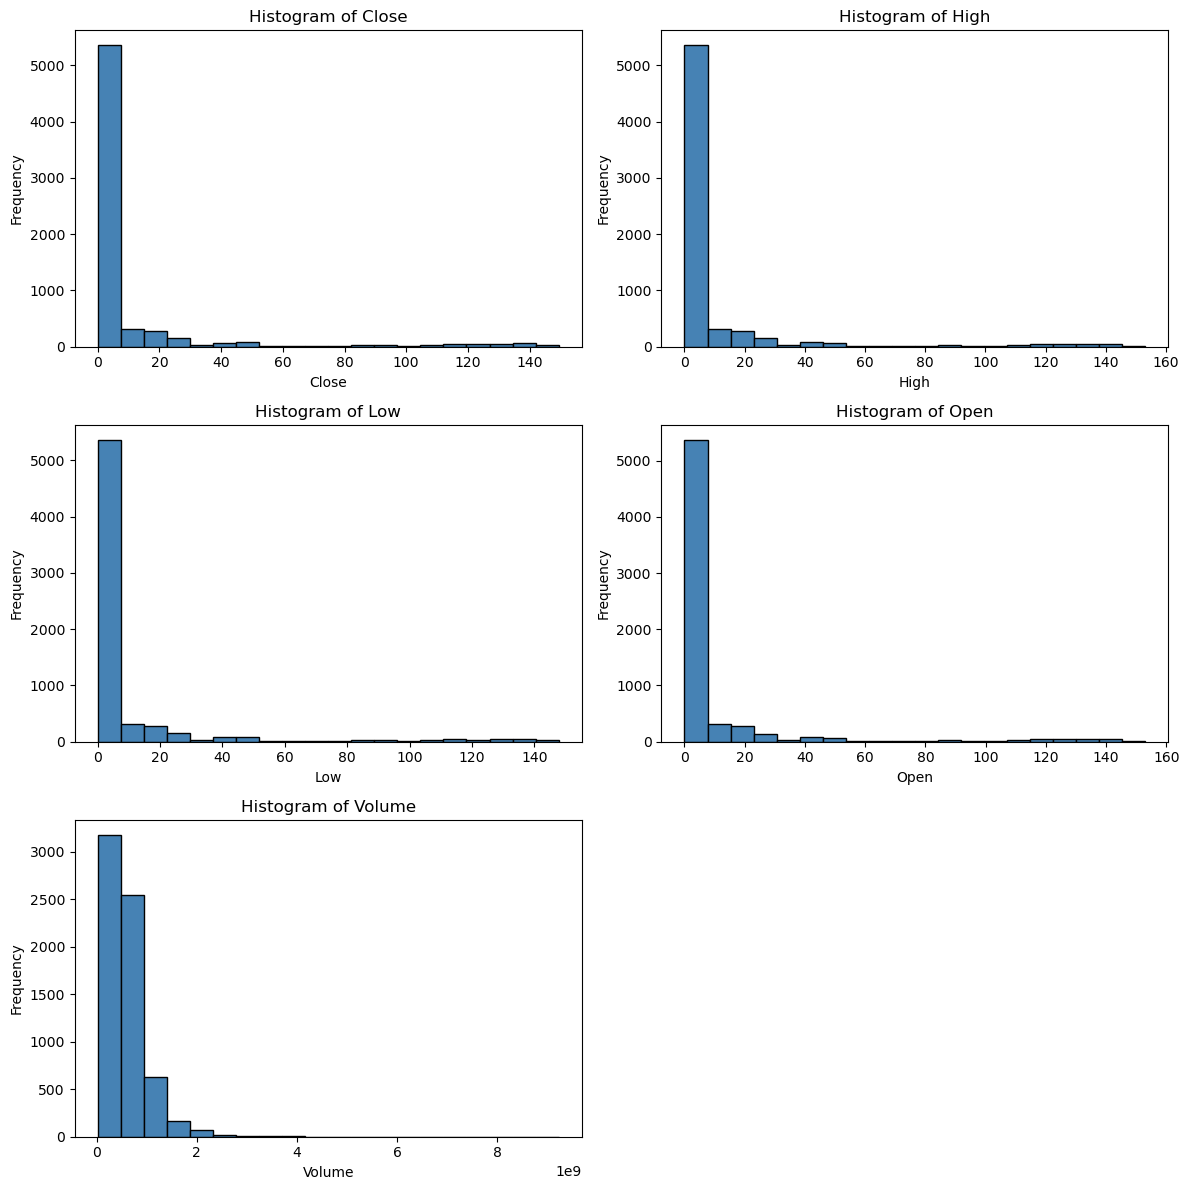

In [25]:
# Drop non-numeric 'Date' column
numeric_df = df.drop(columns=['Date'])

# Determine number of features
features = numeric_df.columns
n_features = len(features)

# Grid layout settings
cols = 2
rows = math.ceil(n_features / cols)

# Create subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
axes = axes.flatten()

# Plot each histogram
for i, col in enumerate(features):
    axes[i].hist(numeric_df[col], bins=20, color='steelblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

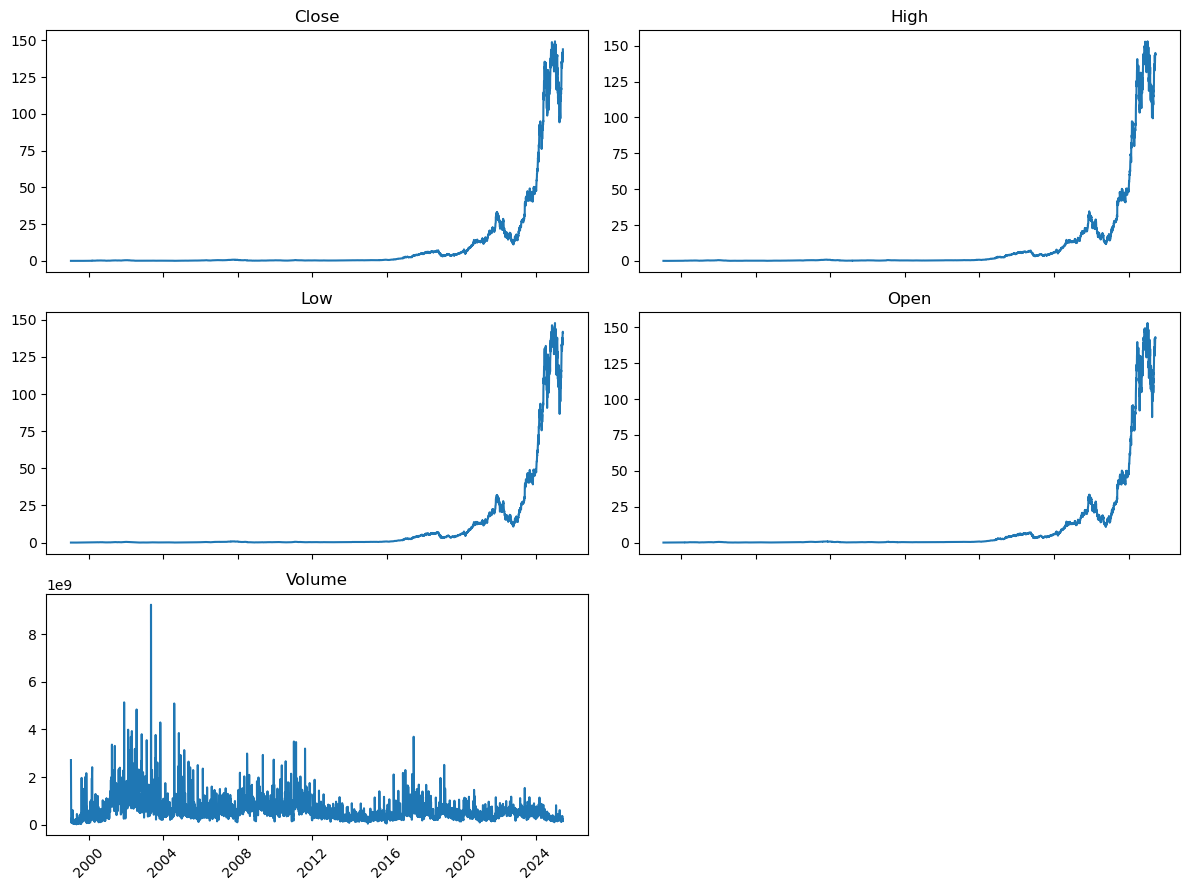

In [26]:
# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3), sharex=True)
axes = axes.flatten()  # Flatten for easy indexing

# Plot each feature as a time series
for i, feature in enumerate(features):
    axes[i].plot(df['Date'], df[feature])
    axes[i].set_title(feature)
    axes[i].tick_params(axis='x', rotation=45)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

## Modelling

### Linear Regression Model

<p>The linear regression model was selected as a baseline approach for predicting NVIDIA’s next-day closing stock price. Linear regression is interpretable and provides a strong foundation for benchmarking more complex models later.</p>

<p><b>Features Used:</b></p>
<ul>
    <li>Lagged closing prices from the past 3 days (`Close_lag1`, `Close_lag2`, `Close_lag3`)</li>
    <li>Lagged volume from the previous day (`Volume_lag1`)</li>
</ul>

<p><b>Target Variable:</b></p>
<p>The target variable was defined as the next day's closing price, created by shifting the `Close` column by -1 (`Target = Close.shift(-1)`).</p>

<p><b>Train-Test Strategy:</b></p>
<p>A time-aware train-test split was used to prevent data leakage by preserving the chronological order of the stock data. 80% of the data was used for training, while the remaining 20% was held out for testing.</p>

<p><b>Limitations:</b></p>
<ul>
    <li>Linear regression assumes a linear relationship between features and target, which may not fully capture stock market dynamics.</li>
    <li>Recent high volatility or price spikes can reduce predictive accuracy.</li>
    <li>Further refinements, such as log-transformations or non-linear models, may be required to improve performance.</li>
</ul>


In [49]:
df["Close_lag1"] = df["Close"].shift(1)
df["Close_lag2"] = df["Close"].shift(2)
df["Close_lag3"] = df["Close"].shift(3)
df["Volume_lag1"] = df["Volume"].shift(1)

features = ["Close_lag1", "Close_lag2", "Close_lag3", "Volume_lag1"]
df["Target"] = df["Close"].shift(-1)

df_model = df[features + ["Target"]].dropna()
X = df_model[features]
y = df_model["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [50]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")

Test MSE: 8.6726


### Predicted vs Actual Closing Prices
<p>The scatter plot compares the model’s predicted closing prices against the actual values from the dataset.</p>
    
<p>The red dashed line represents a perfect 1:1 prediction scenario.</p>

<ul>
    <li>The points lie closely along the diagonal, indicating that the model performs well overall.</li>
    <li>Some deviation is observed at higher price levels, suggesting that the model's predictive power weakens slightly as prices increase.</li>
</ul>

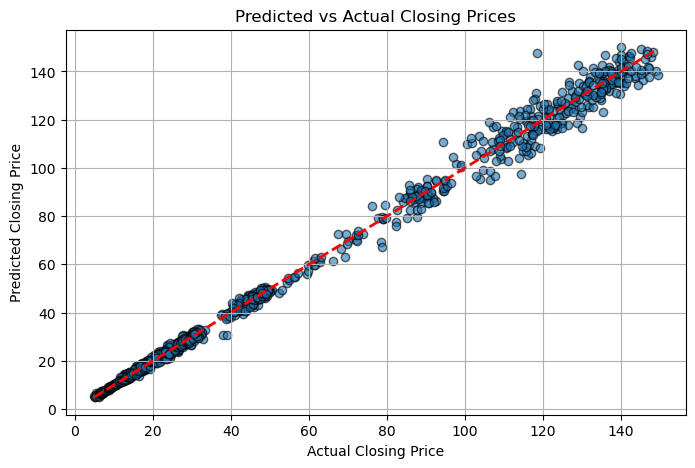

In [51]:
# Calculate residuals
residuals = y_test - y_pred

# Plot predicted vs actual values
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title("Predicted vs Actual Closing Prices")
plt.xlabel("Actual Closing Price")
plt.ylabel("Predicted Closing Price")
plt.grid(True)
plt.show()

### Residual Plot
<p>The residual plot visualises the difference between actual and predicted values (residuals) against the predicted prices.</p>

<ul>
    <li>The residuals are centred around zero, which is a good sign that the model is unbiased on average.</li>
    <li>However, there is a noticeable pattern: residuals spread more widely at higher predicted values, indicating heteroscedasticity (i.e., the variance of the errors increases with price).</li>
    <li>This may suggest the need for model refinement, feature scaling, or a non-linear model to better capture dynamics at higher price ranges.</li>
</ul>

<p>Together, these plots highlight that while the model performs well for most of the data, it may benefit from improvements to handle high-value predictions more robustly.</p>

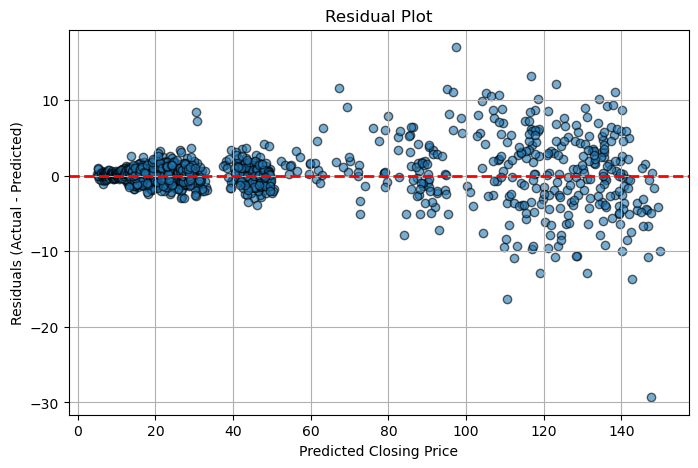

In [52]:
# Residual plot
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title("Residual Plot")
plt.xlabel("Predicted Closing Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.show()

### Cross-Validation

<p>To ensure the robustness of the linear regression model, we applied time series cross-validation using 5 sequential splits. This method respects the temporal order of the data and avoids data leakage.</p>

<p>The model’s performance was evaluated across all folds using R², RMSE, and MAE metrics. The consistency of these scores across different time segments indicates the model’s stability over time. Any variance across folds may highlight shifts in market behavior or limitations in the model’s assumptions.</p>

In [54]:
tscv = TimeSeriesSplit(n_splits=5)

model = LinearRegression()

r2_scores = []
rmse_scores = []
mae_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))

In [55]:
print(f"Average R² Score: {np.mean(r2_scores):.4f}")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")

Average R² Score: 0.9907
Average RMSE: 0.70
Average MAE: 0.42


### Cross-Validation Results Analysis

<p>The linear regression model achieved strong performance across all cross-validation folds, as shown below:</p>

<ul>
  <li><b>Average R² Score: 0.9907</b><br>
  This indicates that the model explains over <b>99% of the variance</b> in the next-day closing prices. It suggests a highly accurate fit to the data within each fold.</li>

  <li><b>Average RMSE: 0.70</b><br>
  The Root Mean Squared Error reflects the average magnitude of prediction errors. A value of 0.70 indicates <b>low average error</b> in absolute price terms, especially considering the scale of NVIDIA stock prices.</li>

  <li><b>Average MAE: 0.42</b><br>
  The Mean Absolute Error is even lower, showing that, on average, the model's predictions deviate from actual values by less than half a dollar per day — a <b>very precise prediction performance</b>.</li>
</ul>

<hr>

<p>These metrics demonstrate that the model performs <b>consistently and reliably across different time periods</b>, without major degradation in unseen (future) data. The high R² score combined with low RMSE and MAE suggests:</p>

<ul>
  <li>The lag features provide strong predictive power.</li>
  <li>The linear model is well-suited to the data's current structure.</li>
  <li>There is minimal overfitting, thanks to time-aware validation.</li>
</ul>

<p><b>However, future work could include:</b></p>
<ul>
  <li>Testing performance during <b>volatile market periods</b>.</li>
  <li>Comparing against <b>non-linear models</b> to explore further improvements.</li>
</ul>